# Package

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [126]:
def initialize_parameters(seed=7, num_agents=1000, m=3, penalty_margin=0.5):
    np.random.seed(seed)
    type_dist = np.random.dirichlet(np.random.uniform(1, 2, m))
    payments, penalties = generate_payments_and_penalties(type_dist, penalty_margin, m)
    return num_agents, m, type_dist, payments, penalties

In [127]:
def generate_payments_and_penalties(type_dist, penalty_margin, m):
    payments = np.zeros(m)
    cumulative = 0
    for i in range(m):
        cumulative += type_dist[i]
        payments[i] = 1 + cumulative / 2
    penalties = payments + penalty_margin
    return payments, penalties

In [128]:
def valuation_function(i, k, payments):
    if k == i:
        return payments[i]
    elif k > i:
        return max(payments[i] - 0.2 * (k - i), 0.0)
    else:
        return max(payments[i] - 0.4 * (i - k), 0.0)

#Principal utility computation

In [129]:
def principal_utility(type_dist, audit_vector, cost, equilibrium_strategy, num_agents, payments, penalties):
    utility = 0
    for idx in range(len(type_dist)):
        reported_type = equilibrium_strategy[idx]
        utility += type_dist[idx] * (
            valuation_function(idx, reported_type, payments)
            - payments[reported_type]
            + audit_vector[reported_type] * (penalties[reported_type] - cost)
        )
    return utility * num_agents

In [130]:
def determine_equilibrium_strategy(payments, penalties, audit_vector, epsilon):
    u_hat = np.max(payments - audit_vector * penalties)
    A_hat = np.where(payments - audit_vector * penalties >= u_hat - epsilon)[0]
    equilibrium_strategy = np.zeros(len(payments), int)
    for idx in range(len(payments)):
        truthful_util = payments[idx]
        equilibrium_strategy[idx] = idx if truthful_util >= u_hat - epsilon else np.min(A_hat)
    return equilibrium_strategy

In [197]:
#search for optimal non-adaptive utility considering epsilon perturbation on critical policies
def optimal_non_adaptive_policy(type_dist, payments, penalties, cost, m, num_agents, epsilon):
    best_utility = -np.inf
    optimal_audit_vector = np.zeros(m)
    # Iterate through critical policy indices
    for i in range(m - 1):
        for u in [payments[i] + epsilon, payments[i + 1] - epsilon]:
            audit_vector = np.zeros(m)
            # set audit probabilities as per critical policy definition
            for k in range(m):
                if k < i:
                    audit_vector[k] = 0  # explicitly zero for k < i
                else:
                    audit_vector[k] = np.clip((payments[k] - u) / penalties[k], 0, 1)
            # Explicit equilibrium strategy
            eq_strategy = determine_equilibrium_strategy(payments, penalties, audit_vector, epsilon)
            utility = principal_utility(type_dist, audit_vector, cost, eq_strategy, num_agents, payments, penalties)
            if utility > best_utility:
                best_utility = utility
                optimal_audit_vector = audit_vector.copy()
    return best_utility, optimal_audit_vector




In [198]:
# search for optimal adaptive utility without epsilon perturbation on critical policies
def optimal_adaptive_policy(type_dist, payments, penalties, cost, m, num_agents):
    epsilon = 0  # explicitly adaptive setting
    best_utility = -np.inf
    optimal_audit_vector = np.zeros(m)
    for i in range(m - 1):
        for u in [payments[i], payments[i + 1]]:
            audit_vector = np.zeros(m)
            # set audit probabilities correctly
            for k in range(m):
                if k < i:
                    audit_vector[k] = 0  #zero for k < i
                else:
                    audit_vector[k] = np.clip((payments[k] - u) / penalties[k], 0, 1)
            eq_strategy = determine_equilibrium_strategy(payments, penalties, audit_vector, epsilon)
            utility = principal_utility(type_dist, audit_vector, cost, eq_strategy, num_agents, payments, penalties)
            if utility > best_utility:
                best_utility = utility
                optimal_audit_vector = audit_vector.copy()
    return best_utility, optimal_audit_vector


In [212]:
# Verify assumptions explicitly as per paper
def verify_assumptions(payments, penalties, cost, type_dist, audit_vector, epsilon=None):
    A1 = np.all(cost <= penalties)
    A2 = np.all(np.diff(payments) / payments[:-1] >= np.diff(penalties) / penalties[:-1])
    A3 = np.all(np.diff(payments) >= 0)
    A4 = np.all(penalties >= payments)
    A5 = np.isclose(np.sum(type_dist), 1)

    if epsilon is not None:
        min_payment_diff = np.min(np.diff(payments))
        A6 = (0 < epsilon) and (epsilon < 0.5 * min_payment_diff)
    else:
        A6 = True

    # Check validity explicitly for the optimal audit vector
    A7 = np.all((audit_vector >= 0) & (audit_vector <= 1))

    return A1, A2, A3, A4, A5, A6, A7

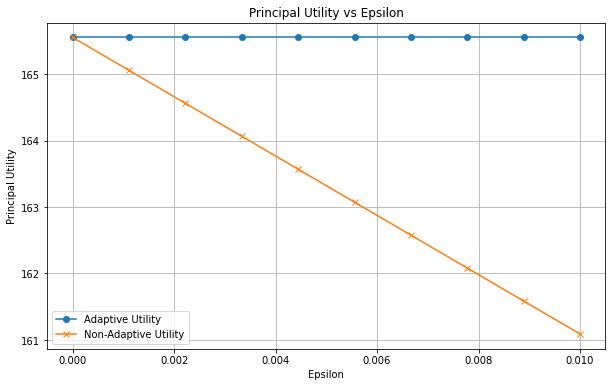

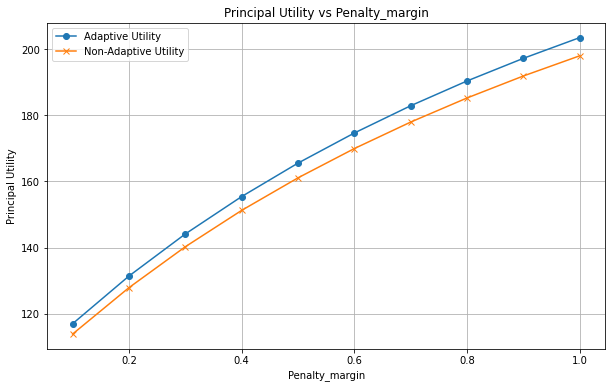

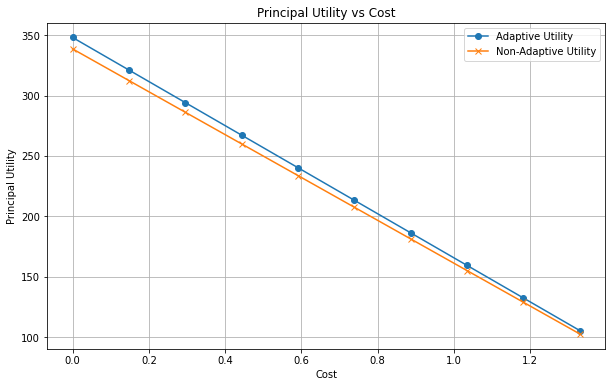

In [234]:
def run_simulation_varying_param(param_name, param_values, fixed_values):
    results_adaptive = []
    results_non_adaptive = []

    violation_reported = False

    for param in param_values:
        # Set parameters
        cost = fixed_values.get('cost', 1.0)
        epsilon = fixed_values.get('epsilon', 1e-6)
        penalty_margin = fixed_values.get('penalty_margin', 0.5)

        if param_name == 'cost':
            cost = param
        elif param_name == 'epsilon':
            epsilon = param
        elif param_name == 'penalty_margin':
            penalty_margin = param
        else:
            raise ValueError("Invalid parameter name.")

        # Initialize parameters
        num_agents, m, type_dist, payments, penalties = initialize_parameters(penalty_margin=penalty_margin)

        # Run adaptive and non-adaptive policies
        adaptive_utility, audit_vector_ad = optimal_adaptive_policy(type_dist, payments, penalties, cost, m, num_agents)
        non_adaptive_utility, audit_vector_na = optimal_non_adaptive_policy(type_dist, payments, penalties, cost, m, num_agents, epsilon)

        results_adaptive.append(adaptive_utility)
        results_non_adaptive.append(non_adaptive_utility)

        if not violation_reported:
            A1, A2, A3, A4, A5, A6, A7_na = verify_assumptions(payments, penalties, cost, type_dist, audit_vector_na, epsilon)
            _, _, _, _, _, _, A7_ad = verify_assumptions(payments, penalties, cost, type_dist, audit_vector_ad, epsilon=0)

            if not (A1 and A2 and A3 and A4 and A5 and A6 and A7_na):
                print(f"Warning: Non-adaptive assumptions violated at {param_name}={param}")
                violation_reported = True

            if not (A1 and A2 and A3 and A4 and A5 and A7_ad):
                print(f"Warning: Adaptive assumptions violated at {param_name}={param}")
                violation_reported = True

    plot_results(param_values, results_adaptive, results_non_adaptive, param_name)

# Plotting function
def plot_results(param_values, adaptive_utility, non_adaptive_utility, param_name):
    plt.figure(figsize=(10, 6))
    plt.plot(param_values, adaptive_utility, label='Adaptive Utility', marker='o')
    plt.plot(param_values, non_adaptive_utility, label='Non-Adaptive Utility', marker='x')
    plt.xlabel(param_name.capitalize())
    plt.ylabel('Principal Utility')
    plt.title(f'Principal Utility vs {param_name.capitalize()}')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example execution
if __name__ == "__main__":
    # Example: vary epsilon
    epsilon_values = np.linspace(0, 0.01, 10)
    run_simulation_varying_param('epsilon', epsilon_values, {'cost': 1.0, 'penalty_margin': 0.5})

    # Example: vary penalty_margin
    penalty_values = np.linspace(0.1, 1.0, 10)
    run_simulation_varying_param('penalty_margin', penalty_values, {'cost': 1.0, 'epsilon': 1e-2})

    # Example: vary cost
    cost_values = np.linspace(0, 1.33, 10)
    run_simulation_varying_param('cost', cost_values, {'epsilon': 1e-2, 'penalty_margin': 0.5})


# 3 agent 3 D figure

In [214]:
from mpl_toolkits.mplot3d import Axes3D

In [232]:
# Simulation for different proportions and epsilon values with simplified assumption checks
def run_simulation_3d(m=3, penalty_margin=0.5, cost=1.0):
    num_agents, m, _, payments, penalties = initialize_parameters(m=m, penalty_margin=penalty_margin)
    epsilon_values = [0.05, 0.01, 0.001, 0.0001, 0.00001]  # Non-adaptive epsilon values

    proportions = np.linspace(0, 1, 20)
    X, Y = np.meshgrid(proportions, proportions)

    fig = plt.figure(figsize=(20, 15))

    for idx, eps in enumerate(epsilon_values, start=1):
        Z_adaptive = np.zeros_like(X)
        Z_non_adaptive = np.zeros_like(X)

        violation_reported = False

        for i in range(len(proportions)):
            for j in range(len(proportions)):
                if X[i, j] + Y[i, j] <= 1:
                    type_dist = np.array([X[i, j], Y[i, j], 1 - X[i, j] - Y[i, j]])

                    utility_na, audit_vector_na = optimal_policy(type_dist, payments, penalties, cost, m, num_agents, epsilon=eps)
                    utility_ad, audit_vector_ad = optimal_policy(type_dist, payments, penalties, cost, m, num_agents, epsilon=0)

                    if not violation_reported:
                        A1, A2, A3, A4, A5, A6, A7_na = verify_assumptions(payments, penalties, cost, type_dist, audit_vector_na, epsilon=eps)
                        _, _, _, _, _, _, A7_ad = verify_assumptions(payments, penalties, cost, type_dist, audit_vector_ad, epsilon=0)

                        if not (A1 and A2 and A3 and A4 and A5 and A6 and A7_na):
                            print(f"Warning: Non-adaptive assumptions violated at epsilon={eps}")
                            violation_reported = True

                        if not (A1 and A2 and A3 and A4 and A5 and A7_ad):
                            print(f"Warning: Adaptive assumptions violated at epsilon=0")
                            violation_reported = True

                    Z_non_adaptive[i, j] = utility_na
                    Z_adaptive[i, j] = utility_ad
                else:
                    Z_non_adaptive[i, j] = np.nan
                    Z_adaptive[i, j] = np.nan

        ax = fig.add_subplot(2, 3, idx, projection='3d')
        ax.plot_surface(X, Y, Z_adaptive, color='blue', alpha=0.7, label='Adaptive (epsilon=0)')
        ax.plot_surface(X, Y, Z_non_adaptive, color='red', alpha=0.7, label=f'Non-Adaptive (epsilon={eps})')

        ax.set_title(f"Adaptive (ε=0, blue) vs Non-Adaptive (ε={eps}, red)", fontsize=14)
        ax.set_xlabel('Proportion of Type 0', fontsize=12)
        ax.set_ylabel('Proportion of Type 1', fontsize=12)
        ax.set_zlabel('Principal Utility', fontsize=12)
        ax.view_init(elev=30, azim=120)

    plt.tight_layout()
    plt.savefig("adaptive_vs_nonadaptive_utilities.png", dpi=300)
    plt.show()

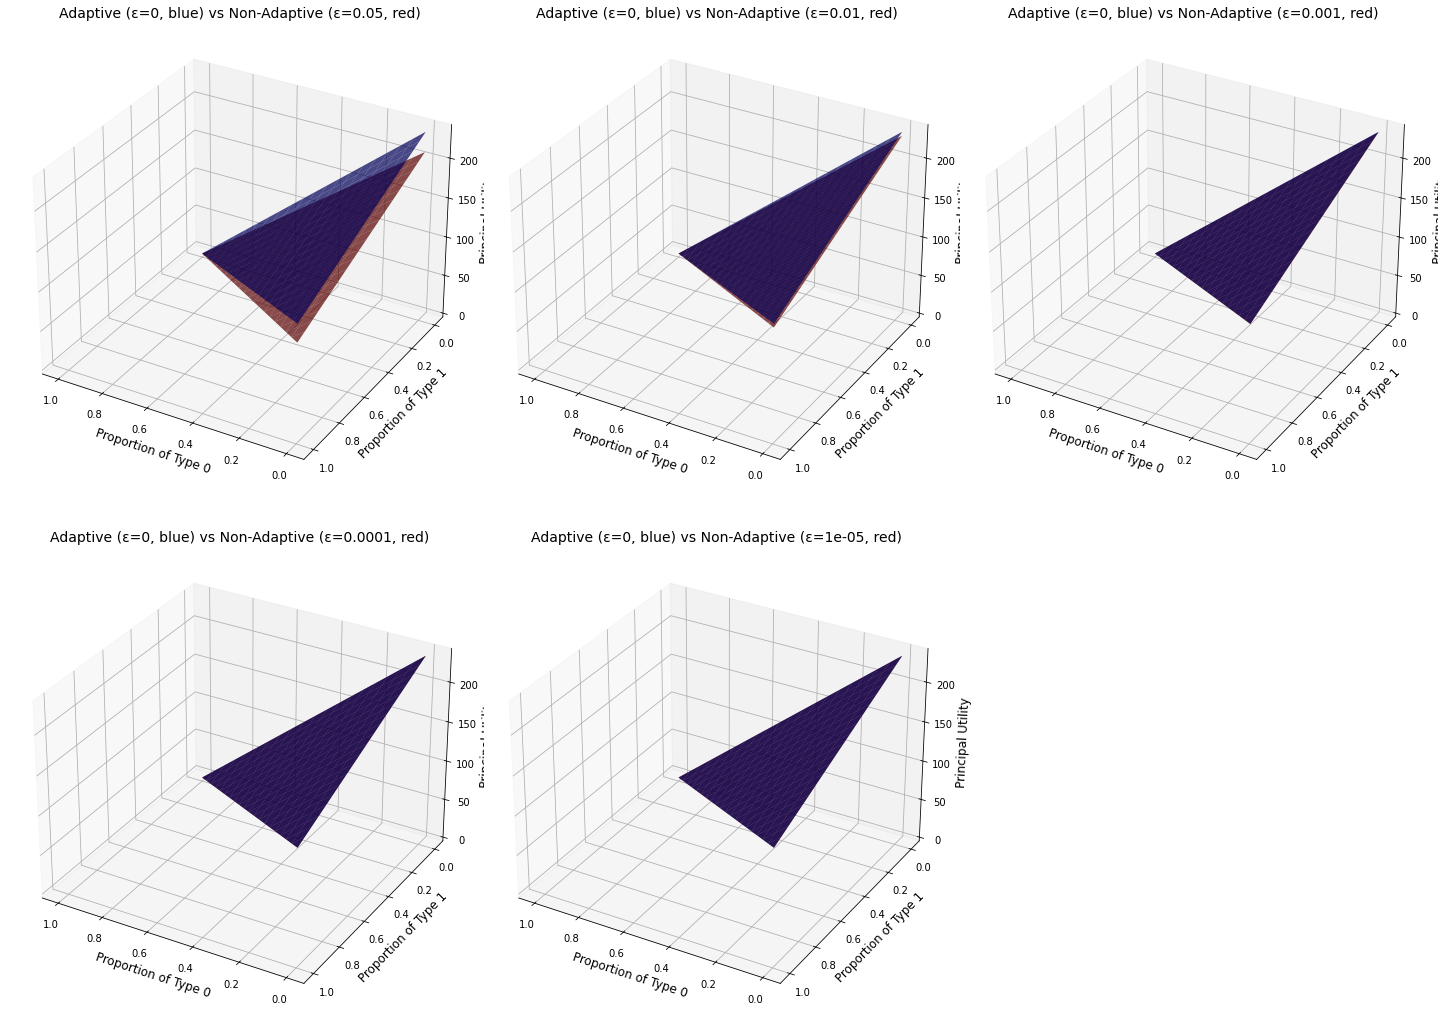

In [233]:
if __name__ == "__main__":
    run_simulation_3d()